# Цель проекта

Обучить модель классифицировать комментарии на позитивные и негативные.
Построить модель со значением метрики качества *F1* не меньше 0.75.

## Подготовка

In [ ]:
!pip install imblearn

     |████████████████████████████████| 235 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.9 MB 35.6 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV)


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from lightgbm import LGBMClassifier


from sklearn.metrics import (
    f1_score,
    confusion_matrix)

from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer)


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    data = pd.read_csv('/content/toxic_comments (1).csv', index_col=0)

In [ ]:
data.sample(10)

,text,toxic
124932,i suggest my balls in yer mouth - no page no r...,1
114733,Unreliable \n\nThis article contains dubious i...,0
123505,I am referencing the Oxford Dictionary of Phil...,0
34866,The map was used by the US government at the...,0
38221,General query \n\nHey. Hi. Hope you are fine. ...,0
10823,"No, this isn't a game walkthrough. 60.242.127.62",0
48360,"its not vandalism\nsee the soursec, it is simp...",0
85614,"""\n\n Request for third opinion \n\nHi Thehist...",0
88564,I am not edit warring. A conscensus has been ...,0
18067,"""\n\nOK, that's fine...I won't argue that """"It...",0


In [ ]:
data.shape

(159292, 2)

In [ ]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

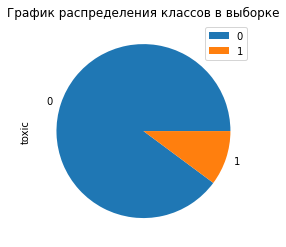

In [ ]:
data['toxic'].value_counts().plot(kind='pie');
plt.title('График распределения классов в выборке');
plt.legend();

Видно, что есть дисбаланс классов. Чтобы повысить качество предсказаний, можно прибегнуть к методам балансировки.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [ ]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [ ]:
data.duplicated().sum()

0

Пропуски и явные дубликаты отсутствуют. Выбока содержит 2 типа данных: int и obj.

In [ ]:
# функция получения POS-тега для слова

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
# функция лемматизации
# функция идёт построчно, пусть каждая строка - это предложение

def lemmatize(sentence):
    lemmatizer = WordNetLemmatizer()

    # разбили предложение на слова
    word_list = nltk.word_tokenize(sentence)

    # лемматизировали каждое слово
    lemm_sentence = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])

    return lemm_sentence

In [ ]:
# приведём к нижнему регистру

data['text'] = data['text'].apply(lambda s: s.lower())

# очистка текста по шаблону

def clean_text(text):
    clean_list = re.sub(r'[^a-zA-Z]', ' ', text)
    clean_text = " ".join(text.split())

    return clean_text

In [ ]:
%%time

from tqdm.notebook import tqdm
tqdm.pandas()

data['text']=data['text'].progress_apply(clean_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 4.57 s, sys: 154 ms, total: 4.73 s
Wall time: 4.99 s


In [ ]:
%%time

# лемматизируем

data['text']=data['text'].progress_apply(lemmatize)

In [ ]:
data['text']

0         explanation why the edits made under my userna...
1         d'aww! he matches this background colour i'm s...
2         hey man, i'm really not trying to edit war. it...
3         " more i can't make any real suggestions on im...
4         you, sir, are my hero. any chance you remember...
                                ...                        
159446    ":::::and for the second time of asking, when ...
159447    you should be ashamed of yourself that is a ho...
159448    spitzer umm, theres no actual article for pros...
159449    and it looks like it was actually you who put ...
159450    " and ... i really don't think you understand....
Name: text, Length: 159292, dtype: object

In [ ]:
# разобьём на выборки, создадим признаки

features = data['text'].values
target = data['toxic']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size = 0.2,
    random_state=42,
    stratify = target)

In [ ]:
features_train[1]

"i'm withdrawing my support. i do not support wikipedia and have now indicated my wishes. as far as i am concerned, wikipedia is stealing my material."

## Обучение

### Логистическая регрессия

In [ ]:
%%time

params={'model__C':[1, 10, 1],
        'model__penalty':['l1','l2']}
        #'model__class_weight': ['balanced']}

pipeline = Pipeline([
    ('count_tf_idf', TfidfVectorizer(stop_words=list(stopwords), max_features = 7000)),
    ('model', LogisticRegression(random_state=42))])



lr_grid = GridSearchCV(pipeline, cv=4, n_jobs=-1, param_grid=params, scoring='f1')
lr_grid.fit(features_train, target_train)
lr_score=lr_grid.best_score_
lr_score

CPU times: user 2min 31s, sys: 1.28 s, total: 2min 32s
Wall time: 2min 33s


0.7681630085613337

### Случайный лес

In [ ]:
%%time

params={'model__max_depth':[1, 10, 1],
         'model__n_estimators':[10, 100, 10],
         'model__class_weight':['balanced']}

pipeline = Pipeline([
    ('count_tf_idf', TfidfVectorizer(stop_words=list(stopwords), max_features = 7000)),
    ('model', RandomForestClassifier(random_state=42))])



rf_grid = GridSearchCV(pipeline, cv=4, n_jobs=-1, param_grid=params, scoring='f1')
rf_grid.fit(features_train, target_train)
rf_score = rf_grid.best_score_
rf_score

In [ ]:
rf_grid.best_params_

### Градиентный бустинг

In [ ]:
%%time

params={'model__n_estimators':[20, 35, 50],
        'model__max_depth':[1, 3, 5]}

pipeline = Pipeline([
    ('count_tf_idf', TfidfVectorizer(stop_words=list(stopwords), max_features = 7000)),
    ('model', LGBMClassifier(random_state=42))])



gb_grid = GridSearchCV(pipeline, cv=4, n_jobs=-1, param_grid=params, scoring='f1')
gb_grid.fit(features_train, target_train)
gb_score=gb_grid.best_score_
gb_score

In [ ]:
# тестирование

score_test = lr_grid.score(features_test, target_test)
print(f'Метрика F1 на тестовых данных  {score_test}')

Метрика F1 на тестовых данных  0.7722260509993109


## Выводы

Моей целью было найти и обучить модель, которая способна классифицировать комментарии на позитивные и негативные для того, чтобы в дальнейшем токсичные отзывы отправлялись на модерацию. При этом достигуть результата предсказания наилучшей модели по мерке F1 не меньше 0.75


В нашем распоряжении был набор данных с разметкой о токсичности правок, но для правильной работы предсказательных алгоритмов моделей нам пришлось очистить комментарии от лишних символов и пр.мусора, а так же прибегнуть к балансировке выборок, т.к. сильный дисбаланс в классах мог негативно повлиять на качество предсказания моделей.

Для определения наилучшей модели мы остановили наш выбор на трёх моделях LGBMClassifier, LogisticRegression и RandomForestClassifier. По итогам сравнеиня победила модель LogisticRegression, набрала наибольшее значение метрики на валидационной выборке  F1=0.76, поэтому её я выбрала для тестирования.

На тестовых данных метрка F1 = 0.772, что подтвердило успешность выбора модели!